In [1]:
import numpy as np
from numpy.random import choice

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.nn import functional as F
from torch.autograd.functional import jacobian

import math

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

import seaborn as sns


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
!pip install cmasher
import cmasher as cmr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.5/506.5 kB 30.8 MB/s eta 0:00:00


In [3]:
# It is recommended data is saved elsewhere for access, i.e. google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# I have broken up my datasets into smaller ones because these datasets are large, so this makes data loading and storage tasks easier
NS = np.load("/content/drive/MyDrive/NavierStokes_dataset_1.pth.npy")
NS_2 = np.load("/content/drive/MyDrive/NavierStokes_dataset_2.pth.npy")
NS_3  = np.load("/content/drive/MyDrive/NavierStokes_dataset_2.pth.npy")

navier_stokes_concat = np.concatenate((NS, NS_2, NS_3), axis=0)

NS_lowres = navier_stokes_concat[:,:,0:80,0:80]

NS_lowres = NS_lowres #np.concatenate((navier_stokes_np, navier_stokes_rotated_90, navier_stokes_rotated_180, navier_stokes_rotated_270), axis=0)

NS_lowres_tens = torch.from_numpy(NS_lowres).type(torch.float32).to(device)
NS_lowres_tens_0 = torch.unsqueeze(NS_lowres_tens[:,0,:,:],dim=1)

In [5]:
print(NS_lowres.shape)

(3000, 7, 80, 80)


In [6]:
# Prepare data

# Create relevant discretizations
N_x = NS_lowres_tens.size(dim=2)
Lt = 1.0
N_t = 7
T = np.linspace(0, Lt, N_t)
T = torch.from_numpy(T)

num_samples = 2500  # Number of Navier-Stokes solutions
num_ICs = 20*num_samples   # Number of grids to be used as training data paired with a random time for output; should be >> num_samples


# Navier-Stokes equation data for neural network input
U = torch.zeros(size=(num_ICs, 1, N_x, N_x)).to(device)
V = torch.zeros(size=(num_ICs, 1, N_x, N_x)).to(device)
times = torch.zeros(size=(num_ICs,1)).to(device)

for num in range(num_ICs):

  rand_i = num % num_samples #np.random.randint(0,num_samples,1)
  time_index = 2*np.random.randint(0, int(T.size(0)/2), 1) #np.random.randint(0, T.size(), 1)

  # Add additional data for final time if desired
  if num > (num_ICs - 3e4):
    time_index = 6

  #time_index = 6

  U[num,:,:,:] = NS_lowres_tens[rand_i,0,:,:]
  times[num,0] = T[time_index]
  V[num,:,:,:] = NS_lowres_tens[rand_i,time_index,:,:]

In [7]:
class parameterization_NN(nn.Module):
  def __init__(self):
    super().__init__()
    self.pool = nn.MaxPool2d(2, 2)
    self.conv1 = nn.Conv2d(1, 10, 5)
    self.conv2 = nn.Conv2d(10, 4, 5)
    self.linear1 = nn.Linear(1156, 500, bias=True)
    self.linear2 = nn.Linear(500, 200, bias=True)
    self.linear3 = nn.Linear(200, 100, bias=True)   # 100 is for domain of 100-sphere immersed
   # self.dropout = nn.Dropout(0.1)

  def forward(self, x):
    x = self.pool(F.elu(self.conv1(x)))
    x = self.pool(F.elu(self.conv2(x)))
    x = torch.flatten(x, 1)
    x = F.elu(self.linear1(x))
    x = F.elu(self.linear2(x))
    x = F.sigmoid(self.linear3(x))
    return x

In [8]:
# Neural network to allow sphere to drift in space to achieve intrinsic manifold behavior
class sphere_shift_NN(nn.Module):
    def __init__(self):
      super().__init__()
      self.linear1 = nn.Linear(1, 80, bias=True)
      self.linear2 = nn.Linear(80, 80, bias=True)
      self.linear3 = nn.Linear(80, 100, bias=True)

    def forward(self, x):
      x = F.elu(self.linear1(x))
      x = F.elu(self.linear2(x))
      x = self.linear3(x)
      return x

In [9]:
# Decodes from point along sphere to solution
class decoder_NN(nn.Module):
    def __init__(self):
      super().__init__()
      self.linear1 = nn.Linear(100, 400, bias=True)
      self.linear2 = nn.Linear(400, 1600, bias=True)
      self.linear3 = nn.Linear(1600, 6400, bias=True)
      self.linear4 = nn.Linear(6400, 6400, bias=True)
      self.linear5 = nn.Linear(6400, 6400, bias=True)
      self.dropout1 = nn.Dropout(0.225)
      self.dropout2 = nn.Dropout(0.325)

    def forward(self, x):
      x = F.elu(self.linear1(x))
      x = self.dropout2(x)
      x = F.elu(self.linear2(x))
      x = self.dropout2(x)
      x = F.elu(self.linear3(x))
      x = self.dropout2(x)
      x = F.elu(self.linear4(x))
      x = self.dropout1(x)
      x = self.linear5(x)
      x = torch.reshape(x, (x.size(dim=0), 1, 80, 80))
      return x

In [15]:
parameterization = parameterization_NN().to(device)
sphere_shift = sphere_shift_NN().to(device)
decoder = decoder_NN().to(device)

In [11]:
optimizer = optim.Adam([
    {'params': parameterization.parameters()},
    {'params': sphere_shift.parameters()},
    {'params': decoder.parameters()}
], lr=1e-4)#, weight_decay = 1e-6)

In [23]:
# Load in pre-trained neural networks from current directory

File = "parameterization.pth"
parameterization.load_state_dict(torch.load(File))

File = "sphere_shift.pth"
sphere_shift.load_state_dict(torch.load(File))

File = "decoder.pth"
decoder.load_state_dict(torch.load(File))

<All keys matched successfully>

In [17]:
# Create function to map parameterization domain to n-sphere subject to Ricci flow

def enc_on_sphere(uv, tau):


  # Initialization
  dim = 100
  radius_0 = 50
  encoded_rep = torch.zeros(size=(N,dim)).to(device)
  radius = torch.zeros(size=(N,1)).to(device)

  #  Define radius for particular time
  radius[:,0] = torch.sqrt( radius_0**2 + 50*(dim-1)*tau.squeeze() )

 # noise = 0.375*torch.randn(size=(N,dim)).to(device)   # 0.375
  noise = 0.0*torch.randn(size=(N,dim)).to(device)

  encoded_rep = radius[:,0].unsqueeze(1) * (uv + noise) / torch.norm(uv + noise, dim=1).unsqueeze(1)

 # encoded_rep = encoded_rep + torch.unsqueeze(radius[:,0],dim=1)*0.12*torch.randn(size=(N,dim)).to(device)   # Empirically we find coefficient 0.075 suitable for noise


  return(encoded_rep)

In [13]:
# Create loss function to evaluate decoded function output loss

def loss_dec_func(parameterization, sphere_shift, decoder, U, V, tau):

  # Compute representation onto the domain for the manifold
  uv = parameterization(U)
  uv = uv  #+ (torch.randn(uv.size()) * 0.003).to(device)   # Empirically we found coefficient 0.035 suitable for noise

  # Compute encoded representation on the manifold
  enc_rep = enc_on_sphere(uv, tau)
  # Shift sphere based on time to make it behave like an intrinsic flow
  shift = sphere_shift(tau)
  enc_shifted = enc_rep + shift
  # Compute decoded representation that is the output function
  dec_rep = decoder(enc_shifted)

  # Difference matrix
  diff = (dec_rep - V)**2

  loss_variation = torch.mean(torch.abs(dec_rep[:, :, :-1, :] - dec_rep[:, :, 1:, :])) + torch.mean(torch.abs(dec_rep[:, :, :, :-1] - dec_rep[:, :, :, 1:]))

  # Return loss
  loss = torch.mean(diff) + 0.1*loss_variation
  return loss

In [14]:
# We have used dropout, so this is necessary for that reason
parameterization.train()
sphere_shift.train()
decoder.train()

decoder_NN(
  (linear1): Linear(in_features=100, out_features=400, bias=True)
  (linear2): Linear(in_features=400, out_features=1600, bias=True)
  (linear3): Linear(in_features=1600, out_features=6400, bias=True)
  (linear4): Linear(in_features=6400, out_features=6400, bias=True)
  (linear5): Linear(in_features=6400, out_features=6400, bias=True)
  (dropout1): Dropout(p=0.225, inplace=False)
  (dropout2): Dropout(p=0.325, inplace=False)
)

In [22]:
# Training algorithm

num_iter = 1000000
N = 800 # batch size


for num in range(num_iter):

  I = np.random.randint(0,int(num_ICs),N)
  tau = times[I,:]

  loss_dec = loss_dec_func(parameterization, sphere_shift, decoder, U[I,:,:,:], V[I,:,:,:], tau)


  loss =  loss_dec

  optimizer.zero_grad()

  loss.backward()

  #torch.nn.utils.clip_grad_value_(parameterization.parameters(), 1.)
  #torch.nn.utils.clip_grad_value_(sphere_shift.parameters(), 1.)
  #torch.nn.utils.clip_grad_value_(decoder.parameters(), 1.)

  optimizer.step()


  if num % 20 == 0:
    print("Training loss:", '{:.4e}'.format(loss.data))

In [ ]:
# Save newly-trained neural networks to current directory

File = "parameterization.pth"
torch.save(parameterization.state_dict(), File)

File = "sphere_shift.pth"
torch.save(sphere_shift.state_dict(), File)

File = "decoder.pth"
torch.save(decoder.state_dict(), File)

In [ ]:
from cmasher import seasons_s

In [18]:
# Define a heat map plot
def heatmap2d(data):
  cmap = cmr.iceburn
  fig, (ax) = plt.subplots(1,1, figsize=(5,5))
  ax = sns.heatmap(data, ax=ax, cmap=cmap, square=True, cbar=True, cbar_kws={'shrink': 0.805})

  ax.set(xticklabels=[]); ax.set(yticklabels=[]); ax.tick_params(left=False, bottom=False)
  plt.savefig("navierstokes.png", dpi=300)
  plt.xticks(rotation=0)
  plt.show()

In [19]:
# Create function to map parameterization domain to n-sphere subject to Ricci flow

def enc_on_sphere_test(uv, tau):


  # Initialization
  dim = 200
  radius_0 = 50
  encoded_rep = torch.zeros(size=(N,dim)).to(device)
  radius = torch.zeros(size=(N,1)).to(device)

  #  Define radius for particular time
  radius[:,0] = torch.sqrt( radius_0**2 + 50*(dim-1)*tau.squeeze() )

  encoded_rep = radius[:,0].unsqueeze(1) * uv / torch.norm(uv, dim=1).unsqueeze(1)

  encoded_rep = encoded_rep    # Empirically we find coefficient 0.075 suitable for noise


  return(encoded_rep)

In [20]:
parameterization.eval()
sphere_shift.eval()
decoder.eval()

decoder_NN(
  (linear1): Linear(in_features=100, out_features=400, bias=True)
  (linear2): Linear(in_features=400, out_features=1600, bias=True)
  (linear3): Linear(in_features=1600, out_features=6400, bias=True)
  (linear4): Linear(in_features=6400, out_features=6400, bias=True)
  (linear5): Linear(in_features=6400, out_features=6400, bias=True)
  (dropout1): Dropout(p=0.225, inplace=False)
  (dropout2): Dropout(p=0.325, inplace=False)
)

In [30]:
# Evaluate test solution

#np.random.seed(7)



solution_index = np.random.randint(2500,3000,1).squeeze()  # Choose test data here, where index \in {test indices}
U_test = NS_lowres_tens_0[solution_index,:,:,:]
U_test = torch.unsqueeze(U_test,dim=0)
parameterization_test = parameterization(U_test)
index_test = 6 # Choose time index for solution. Should be i i\in [0,19]
time_test = torch.unsqueeze(torch.unsqueeze(T[index_test],dim=0),dim=0).type(torch.float32).to(device)

enc_test = enc_on_sphere_test(parameterization_test, time_test)
shift_test = sphere_shift(time_test)
enc_shifted_test = enc_test #+ shift_test
dec_test = decoder(enc_shifted_test)

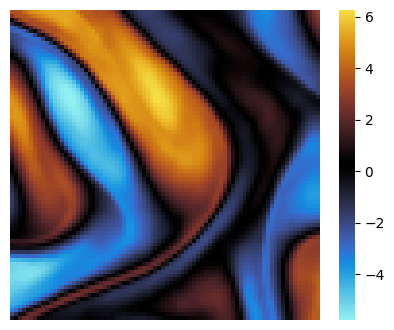

In [31]:
heatmap2d(dec_test[0,0,:,:].cpu().detach().numpy())

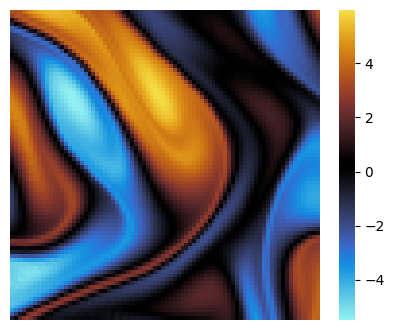

In [32]:
heatmap2d(NS_lowres_tens[solution_index,index_test,:,:].cpu().detach().numpy())

In [37]:
# Evaluate test solution with noise

np.random.seed(42)

# 2795 # Sample for main figure


#noise = torch.from_numpy(np.random.normal(0,2.0, size=(50,50))).type(torch.float32).to(device)
noise = torch.from_numpy(np.random.normal(0,4.0, size=(25,25))).type(torch.float32).to(device)

solution_index = 2795   #2805    #np.random.randint(2500,3000,1).squeeze()  # Choose test data here, where index \in {test indices}
U_test = NS_lowres_tens_0[solution_index,:,:,:].clone()
U_test[0,40:65,40:65] += noise  # Add in noise
U_test = torch.unsqueeze(U_test,dim=0)

parameterization_test = parameterization(U_test)
index_test = 6 # Choose time index for solution. Should be i i\in [0,19]
time_test = torch.unsqueeze(torch.unsqueeze(T[index_test],dim=0),dim=0).type(torch.float32).to(device)

enc_test = enc_on_sphere_test(parameterization_test, time_test)
shift_test = sphere_shift(time_test)
enc_shifted_test = enc_test + shift_test
dec_test = decoder(enc_shifted_test)

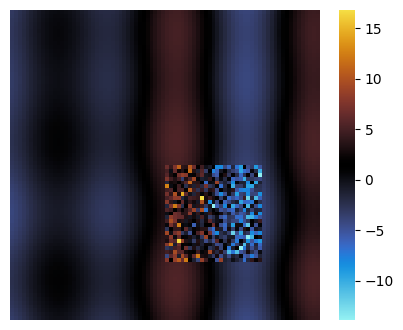

In [38]:
heatmap2d(U_test[0,0,:,:].cpu().detach().numpy())

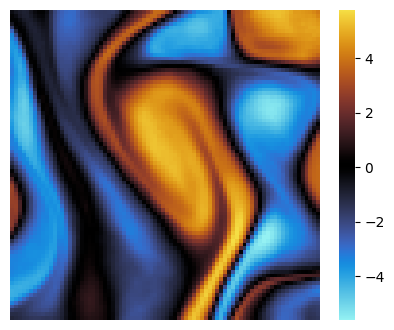

In [39]:
heatmap2d(dec_test[0,0,:,:].cpu().detach().numpy())

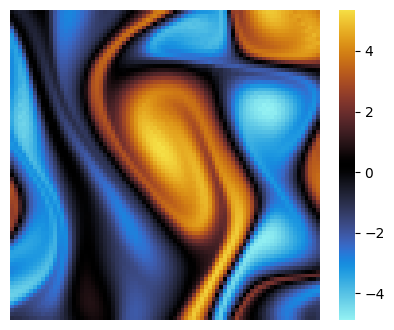

In [40]:
heatmap2d(NS_lowres_tens[solution_index,index_test,:,:].cpu().detach().numpy())

In [57]:
# Evaluate test solution with noise

np.random.seed(42)

# 2795 # Sample for main figure


#noise = torch.from_numpy(np.random.normal(0,2.0, size=(50,50))).type(torch.float32).to(device)
noise = torch.from_numpy(np.random.normal(0,6.0, size=(25,25))).type(torch.float32).to(device)

solution_index = 2795   #2805    #np.random.randint(2500,3000,1).squeeze()  # Choose test data here, where index \in {test indices}
U_test = NS_lowres_tens_0[solution_index,:,:,:].clone()
U_test[0,40:65,40:65] += noise  # Add in noise
U_test = torch.unsqueeze(U_test,dim=0)

parameterization_test = parameterization(U_test)
index_test = 6 # Choose time index for solution. Should be i i\in [0,19]
time_test = torch.unsqueeze(torch.unsqueeze(T[index_test],dim=0),dim=0).type(torch.float32).to(device)

enc_test = enc_on_sphere_test(parameterization_test, time_test)
shift_test = sphere_shift(time_test)
enc_shifted_test = enc_test + shift_test
dec_test = decoder(enc_shifted_test)

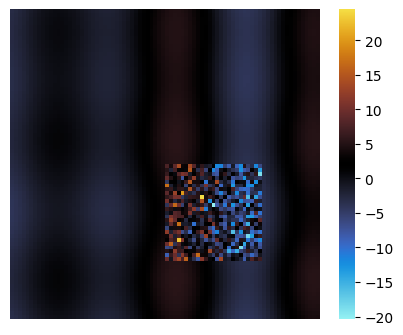

In [58]:
heatmap2d(U_test[0,0,:,:].cpu().detach().numpy())

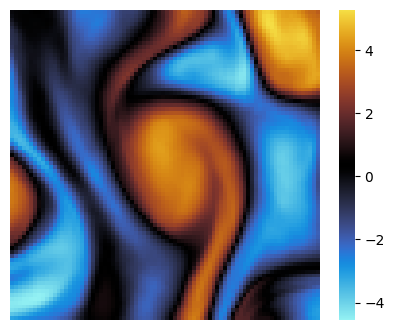

In [59]:
heatmap2d(dec_test[0,0,:,:].cpu().detach().numpy())

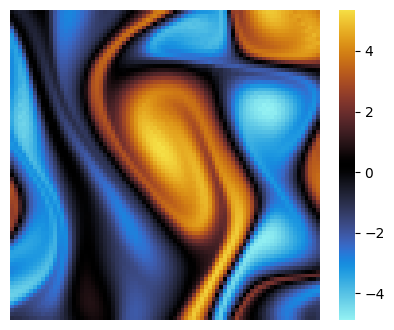

In [60]:
heatmap2d(NS_lowres_tens[solution_index,index_test,:,:].cpu().detach().numpy())